In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/strokedata/stroke data (1).csv


In [2]:
stroke = pd.read_csv('/kaggle/input/strokedata/stroke data (1).csv')

# Data Cleaning / Feature Preparation

In [3]:
#NA Values in smoke_status column
stroke['smoking_status'].fillna('Unknown', inplace = True)

#NA values in Metric 2 column
stroke.columns[stroke.isna().any()]
stroke['metric_2'].fillna(stroke['metric_2'].mean(), inplace=True)

#Checking Null Values
stroke.columns[stroke.isnull().any()]

#Remove ID column
stroke.drop('id', axis=1, inplace=True)

In [4]:
#Normalizing continuous data
stroke_m = stroke.drop(columns = ['stroke'])
mean = stroke_m.drop(columns=['gender', 'married', 'hypertension', 'heart_disease', 'occupation', 'residence', 'metric_3', 'smoking_status']).mean()
std  = stroke_m.drop(columns=['gender', 'married', 'hypertension', 'heart_disease', 'occupation', 'residence', 'metric_3', 'smoking_status']).std()
stroke_m = (stroke_m.drop(columns=['gender', 'married', 'hypertension', 'heart_disease', 'occupation', 'residence', 'metric_3', 'smoking_status']) - mean)/std
stroke_m #only normalized continuous values
['gender', 'married', 'occupation', 'residence', 'smoking_status']

#One hot Encoding
cols = ['gender', 'married', 'occupation', 'residence', 'smoking_status']
stroke_r = stroke[cols]
stroke_r = pd.get_dummies(stroke_r, columns=cols)
#Join both columns
main_stroke = pd.concat([stroke_m, stroke_r], axis = 1)

ams = ['hypertension', 'heart_disease','metric_3']
main_stroke[ams] = stroke[ams]

main_stroke['stroke'] = stroke['stroke']
main_stroke['stroke'].value_counts()


0    42617
1      783
Name: stroke, dtype: int64

The data is heavily imbalanced with 783 cases of individuals who have experienced a stroke while 42617 who havent. Hence the data will be both oversampled and undersampled to address this discrepancy. 

In [5]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

X = main_stroke.drop('stroke', axis=1)
y = main_stroke['stroke']

# Apply the random undersampling
undersample = RandomUnderSampler(sampling_strategy=0.05)
X_under, y_under = undersample.fit_resample(X, y)

# Apply SMOTE to the undersampled dataset
oversample = SMOTE(sampling_strategy=0.5)
X_balanced, y_balanced = oversample.fit_resample(X_under, y_under)
y_balanced.value_counts()
X_balanced

,age,metric_1,metric_2,metric_4,metric_5,gender_Female,gender_Male,gender_Other,married_No,married_Yes,...,occupation_E,residence_Rural,residence_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,hypertension,heart_disease,metric_3
0,-0.096473,-1.119944,0.261188,0.363499,-1.119944,1,0,0,0,1,...,1,0,1,0,0,0,1,0,0,0
1,-0.480449,-0.969637,0.941993,0.922576,-0.969637,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
2,0.714145,-0.076377,0.169541,-0.066036,-0.076377,1,0,0,0,1,...,1,0,1,0,1,0,0,0,0,0
3,0.287504,0.772579,-0.733834,-0.795563,0.772579,1,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0
4,-0.267129,-0.417583,-1.021866,0.411225,-0.417583,1,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23485,0.368385,-0.568702,0.000000,-0.246990,-0.568702,1,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
23486,1.119990,2.061175,0.002608,-2.227981,2.061175,0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0
23487,0.352160,-0.509781,2.271655,-0.791728,-0.509781,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
23488,0.604391,-0.800828,0.012520,1.295881,-0.800828,0,1,0,0,1,...,0,1,0,0,0,0,1,0,0,0


# Logistic Regression

In [6]:
#Convert to np arrays
x_features = X_balanced.values
y_features = y_balanced.values

# Reshape x_features and y_features to column vectors
x_features = x_features.reshape(-1, x_features.shape[1])
y_features = y_features.reshape(-1, 1)
# Split the data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(x_features, y_features, test_size=0.3, random_state=42)
x_validation, x_test, y_validation, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shapes:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)

print("\nValidation set shapes:")
print("x_validation:", x_validation.shape)
print("y_validation:", y_validation.shape)

print("\nTest set shapes:")
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

Training set shapes:
x_train: (16443, 24)
y_train: (16443, 1)

Validation set shapes:
x_validation: (3523, 24)
y_validation: (3523, 1)

Test set shapes:
x_test: (3524, 24)
y_test: (3524, 1)


In [7]:
#sigmoid
def sigmoid(k):    
    sigs = 1 / (1 + np.exp(-k))
    return sigs

#cost function (taking Adv of Numpy broadcasting etc.)
def cost_f(x, y, w_in, b_in, Lam):
    
    m = x.shape[0]
    
    f_x = np.dot(x, w_in) + b_in
    sig = sigmoid(f_x)
    
    epsilon = 1e-7  # small constant

#     The constant epsilon has been added. I was facing an issue where the argument of no.log was very close to 0 and
#     thus was producing cost functions which were infinitely large. The epsilon offsets the np.log argument and prevents
#     this.
    loss = -y * np.log(sig + epsilon) - (1 - y) * np.log(1 - sig + epsilon)
    reg_term = (Lam / (2 * m)) * np.sum(w_in ** 2)
    
    total_cost = (1 / m) * (np.sum(loss) + reg_term)
    return total_cost

#Grad Descent
def grad(x, y, w_in, b_in, L, Lam):
   
    m = x.shape[0]    
    
    f_x = np.dot(x,w_in) + b_in
    sig = sigmoid(f_x)
        
    reg_term = (Lam/m) * w_in
    
    w_g = (1 / m) * np.dot(x.T, sig - y) + reg_term
    b_g = (1 / m) * np.sum(sig - y)
    
    w = w_in - L * w_g
    b = b_in - L * b_g
    return w, b   


# Optimizing Lambda and Learning Rate

In [8]:
# Define the hyperparameter grid
L_values = [0.001, 0.01, 0.1, 1]
Lam_values = [0.001, 0.01, 0.1, 1, 10, 50]

# Initialize variables
w = np.zeros((x_train.shape[1], 1))  # Initialize w with the correct shape
b = 0
epoch = 2000

# Initialize lists to store the results
best_L = None
best_Lam = None
best_cost = float('inf')

# Perform the grid search
for L in L_values:
    for Lam in Lam_values:
        # Reset the weights and bias
        w.fill(0)
        b = 0
        
        # Training loop
        for i in range(epoch):
            w, b = grad(x_train, y_train, w, b, L, Lam)
        
        # Calculate the cost on the validation set (the Lam and L values are calculated
        #using train/test but evaluated using the validation set to avoid overfitting)
        
        cost = cost_f(x_validation, y_validation, w, b, Lam)
        
        # Update the best hyperparameters if necessary
        if cost < best_cost:
            best_L = L
            best_Lam = Lam
            best_cost = cost

# Print the best hyperparameters
print(f"Best L: {best_L}, Best Lam: {best_Lam}")

Best L: 1, Best Lam: 0.001


In [9]:
# Initialize variables
w = np.zeros((x_train.shape[1], 1))  # Initialize w with the correct shape
b = 0
L = 1
Lam = 0.001
epoch = 2000
print_epochs = []
print_costs = []
cost_hist = []

# Training loop

for i in range(epoch):
    w, b = grad(x_train, y_train, w, b, L,Lam)
    
    if i % 200 == 0:
        print_epochs.append(i)
        cost = cost_f(x_train, y_train, w, b,Lam)
        print_costs.append(cost)
    
    cost = cost_f(x_train, y_train, w, b,Lam)
    cost_hist.append(cost)

# Print results
print("Epochs and Costs:")
for epoch, cost in zip(print_epochs, print_costs):
    print(f"Epoch: {epoch}, Cost: {cost}")

print("Final values:")
print(f"Final w: {w}, Final b: {b}")

Epochs and Costs:
Epoch: 0, Cost: 0.5732214897072735
Epoch: 200, Cost: 0.38985723924069304
Epoch: 400, Cost: 0.37471590907679797
Epoch: 600, Cost: 0.3641336357559871
Epoch: 800, Cost: 0.3562220259483754
Epoch: 1000, Cost: 0.3500478100645056
Epoch: 1200, Cost: 0.34508626600828257
Epoch: 1400, Cost: 0.3410130465827051
Epoch: 1600, Cost: 0.33761321611952827
Epoch: 1800, Cost: 0.33473696180395623
Final values:
Final w: [[ 2.01725209]
 [ 0.05007959]
 [-0.09794728]
 [-0.037982  ]
 [ 0.05007959]
 [-1.98358392]
 [-1.80689848]
 [ 0.        ]
 [-2.23492291]
 [-1.42450559]
 [-1.0514461 ]
 [-2.17555022]
 [-0.12717132]
 [-2.43653839]
 [-3.03026311]
 [-1.67363977]
 [-1.60017378]
 [-3.17343096]
 [-2.9350844 ]
 [-3.02546926]
 [-2.75357596]
 [-0.33358782]
 [-0.38516385]
 [-0.66905923]], Final b: 8.089419281126


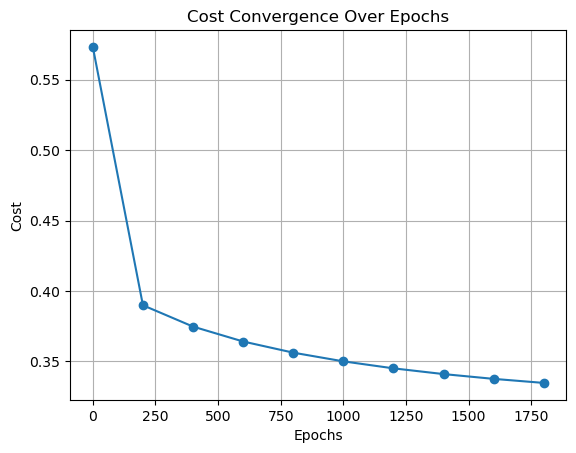

In [10]:
#Visualizing the decrease in Cost
plt.plot(print_epochs, print_costs, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Cost Convergence Over Epochs')
plt.grid()
plt.show()

# Interpretation of the Model

In [11]:
from sklearn.metrics import confusion_matrix, classification_report

# Calculate the predicted values
y_pred = 1 / (1 + np.exp(-(np.dot(x_test, w) + b))) > 0.5

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print('Confusion Matrix:')
print(cm)

# Calculate the classification report
cr = classification_report(y_test, y_pred)

# Print the classification report
print('Classification Report:')
print(cr)

Confusion Matrix:
[[2093  249]
 [ 320  862]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2342
           1       0.78      0.73      0.75      1182

    accuracy                           0.84      3524
   macro avg       0.82      0.81      0.82      3524
weighted avg       0.84      0.84      0.84      3524



# Interpretation/Analysis of the Results

In the analysis, the confusion matrix reveals the model's predictive performance across two classes: class 0 and class 1. For class 0, the model accurately predicted 2089 instances while incorrectly classifying 253 instances. In the case of class 1, the model achieved 870 correct predictions and made 312 incorrect predictions.
The classification report provides an evaluation of the model's accuracy within each class. The model shows a 87% accuracy when identifying individuals who did not/would not experience a stroke based on their data. For individuals who did have/would have a stroke, the model achieved an accuracy of 77%.
The overall accuracy of the model stands at 84%, being able to make accurate predictions across both classes. The macro average F1-score was calculated at 82%, indicating a balanced performance across the two classes. The weighted average F1-score, which takes class imbalances into account, was also calculated at 84%. These metrics collectively display the model's ability to make fairly accurate predictions across the dataset.